In [1]:
%load_ext autoreload 
%autoreload 2

# Exp4 Pretrain DCGAN to obtain feature extractor

In [2]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from networks import weights_init, Generator_64, Discriminator_64, Generator_128_v2, Discriminator_128_v2
from loader import All_fundus_files

In [3]:
# settings
dataroot = None
batch_size = 128
image_size = 128 #size using data aug.

ch_out = 3 
ch_noise = 100
ch_g = 64
ch_d = 64

num_epochs = 50
lr = 0.0002
beta1 = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# dataloader
'''
train_dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
'''
train_dataset = All_fundus_files(transform=transforms.Compose([
                           transforms.Resize(image_size),
                           transforms.CenterCrop(image_size),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
print(len(train_dataset))

# networks
#net_G = Generator_64(ch_noise, ch_g, ch_out).to(device)
net_G = Generator_128_v2(ch_noise, ch_g, ch_out).to(device)
net_G.apply(weights_init)
print(net_G)

#net_D = Discriminator_64(ch_out, ch_d).to(device)
net_D = Discriminator_128_v2(ch_out, ch_d).to(device)
net_D.apply(weights_init)
print(net_D)

# loss and optimizer
criterion = nn.BCELoss()
optimizer_D = optim.Adam(net_D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = optim.Adam(net_G.parameters(), lr=lr, betas=(beta1, 0.999))
lr_scheduler_G = optim.lr_scheduler.MultiStepLR(optimizer_D, [10,25], gamma=0.1)
lr_scheduler_D = optim.lr_scheduler.MultiStepLR(optimizer_G, [10,25], gamma=0.1)

41317
41317
Generator_128_v2(
  (backbone): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=

In [5]:
def cv2_imwrite(path, image):
    image = np.clip(np.round(image*255),0,255)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)

### Adding tricks to improve convergence
# https://github.com/soumith/ganhacks
# adding soft label and label noise
def train_one_epoch(epoch, dataloader, net_G, net_D, optimizer_G, optimizer_D, num_epochs, fixed_noise, ch_noise, device):
    G_losses = []
    D_losses = []
    for iteration, data in enumerate(dataloader, 0):
        ### Update D
        net_G.train()
        net_D.train()
        #data
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        #real_label = torch.ones((batch_size,), dtype=torch.float, device=device)
        real_label_tmp = torch.rand((batch_size,))*0.5+0.7 #use soft label
        
        noise = torch.randn(batch_size, ch_noise, 1, 1, device=device) #(b,c,1,1)
        fake_data = net_G(noise)
        #fake_label = torch.zeros((batch_size,), dtype=torch.float, device=device)
        fake_label_tmp = torch.rand((batch_size,))*0.3
        
        if torch.rand(1) < 0.05: #add label noise
            real_label = fake_label_tmp.to(device)
            fake_label = real_label_tmp.to(device)
        else:
            real_label = real_label_tmp.to(device)
            fake_label = fake_label_tmp.to(device)
        
        #forward
        real_output = net_D(real_data).view(-1)
        fake_output = net_D(fake_data.detach()).view(-1)
        real_loss_D = criterion(real_output, real_label)
        fake_loss_D = criterion(fake_output, fake_label)
        loss_D = real_loss_D + fake_loss_D
        
        #backward
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()
        

        ### Update G
        #real_label = torch.ones((batch_size,), dtype=torch.float, device=device)
        real_label = torch.rand((batch_size,))*0.5+0.7
        real_label = real_label.to(device)
        fake_output_G = net_D(fake_data).view(-1)
        loss_G = criterion(fake_output_G, real_label)
        
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        
        # logs
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        if iteration % 50 == 0:
            print('[{:d}/{:d}] Iter:{:d}  Loss_D={:.4f} Loss_G={:.4f} D(x)={:.4f} D(G(z))={:.4f}, {:.4f}'.format(
                  epoch, num_epochs, iteration+1, loss_D.item(), loss_G.item(), real_output.mean().item(), fake_output.mean().item(), fake_output_G.mean().item()))
        
        # test
        if (iteration == len(dataloader)//2) or (iteration == len(dataloader)-1):
            net_G.eval()
            net_D.eval()
            with torch.no_grad():
                fake_images = net_G(fixed_noise).detach().cpu()
            fake_images = np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True),(1,2,0))
            #print(fake_images)
            cv2_imwrite('./fig_exp4/epoch{}Iter{}.png'.format(epoch, iteration), fake_images.numpy())
    return G_losses, D_losses


In [6]:
# Training
G_losses = []
D_losses = []
fixed_noise = torch.randn(64, ch_noise, 1, 1, device=device)
# For each epoch
for epoch in range(num_epochs):
    g,d = train_one_epoch(epoch, train_dataloader, net_G, net_D, optimizer_G, optimizer_D, num_epochs, fixed_noise, ch_noise, device)
    G_losses += g
    D_losses += d
    lr_scheduler_G.step()
    lr_scheduler_D.step()

[0/50] Iter:1  Loss_D=2.3381 Loss_G=15.7753 D(x)=0.5922 D(G(z))=0.7511, 0.0000
[0/50] Iter:51  Loss_D=8.7841 Loss_G=54.4597 D(x)=0.9387 D(G(z))=0.0000, 0.0000
[0/50] Iter:101  Loss_D=2.8827 Loss_G=0.2791 D(x)=0.9496 D(G(z))=0.0001, 0.9916
[0/50] Iter:151  Loss_D=0.9779 Loss_G=2.2863 D(x)=0.8091 D(G(z))=0.2622, 0.1291
[0/50] Iter:201  Loss_D=1.0624 Loss_G=2.4700 D(x)=0.8261 D(G(z))=0.4600, 0.1012
[0/50] Iter:251  Loss_D=1.0618 Loss_G=1.8679 D(x)=0.6532 D(G(z))=0.2136, 0.1665
[0/50] Iter:301  Loss_D=1.3611 Loss_G=0.8628 D(x)=0.4719 D(G(z))=0.1591, 0.4381
[1/50] Iter:1  Loss_D=1.8760 Loss_G=0.8011 D(x)=0.6547 D(G(z))=0.5645, 0.4789
[1/50] Iter:51  Loss_D=1.0270 Loss_G=1.2636 D(x)=0.6620 D(G(z))=0.1832, 0.2957
[1/50] Iter:101  Loss_D=1.0520 Loss_G=3.0014 D(x)=0.9316 D(G(z))=0.5425, 0.0497
[1/50] Iter:151  Loss_D=1.1932 Loss_G=4.0413 D(x)=0.9437 D(G(z))=0.6108, 0.0192
[1/50] Iter:201  Loss_D=0.9435 Loss_G=1.4019 D(x)=0.7398 D(G(z))=0.1908, 0.2610
[1/50] Iter:251  Loss_D=1.1648 Loss_G=1.3844

[14/50] Iter:251  Loss_D=0.8786 Loss_G=1.1916 D(x)=0.7751 D(G(z))=0.3393, 0.3240
[14/50] Iter:301  Loss_D=0.9217 Loss_G=1.1325 D(x)=0.7290 D(G(z))=0.3075, 0.3363
[15/50] Iter:1  Loss_D=0.9123 Loss_G=1.3312 D(x)=0.8113 D(G(z))=0.3243, 0.2878
[15/50] Iter:51  Loss_D=1.0142 Loss_G=1.1874 D(x)=0.7332 D(G(z))=0.3831, 0.3167
[15/50] Iter:101  Loss_D=0.9252 Loss_G=1.0212 D(x)=0.7476 D(G(z))=0.3413, 0.3666
[15/50] Iter:151  Loss_D=0.8330 Loss_G=1.2007 D(x)=0.7754 D(G(z))=0.3190, 0.3156
[15/50] Iter:201  Loss_D=0.9843 Loss_G=1.1884 D(x)=0.7646 D(G(z))=0.3952, 0.3257
[15/50] Iter:251  Loss_D=2.8280 Loss_G=1.0196 D(x)=0.7768 D(G(z))=0.3191, 0.3903
[15/50] Iter:301  Loss_D=0.9806 Loss_G=1.2026 D(x)=0.7897 D(G(z))=0.4061, 0.3114
[16/50] Iter:1  Loss_D=0.9589 Loss_G=1.1805 D(x)=0.7240 D(G(z))=0.2860, 0.3240
[16/50] Iter:51  Loss_D=0.8928 Loss_G=1.2555 D(x)=0.8127 D(G(z))=0.3519, 0.3013
[16/50] Iter:101  Loss_D=0.8930 Loss_G=1.2833 D(x)=0.7661 D(G(z))=0.2950, 0.2977
[16/50] Iter:151  Loss_D=0.8511 Lo

[29/50] Iter:101  Loss_D=0.8016 Loss_G=1.3464 D(x)=0.8213 D(G(z))=0.2742, 0.2768
[29/50] Iter:151  Loss_D=0.8283 Loss_G=1.3030 D(x)=0.8080 D(G(z))=0.3015, 0.2951
[29/50] Iter:201  Loss_D=0.9057 Loss_G=1.2444 D(x)=0.7864 D(G(z))=0.3019, 0.3001
[29/50] Iter:251  Loss_D=0.8067 Loss_G=1.2934 D(x)=0.8136 D(G(z))=0.2961, 0.2937
[29/50] Iter:301  Loss_D=0.8889 Loss_G=1.1823 D(x)=0.7752 D(G(z))=0.3109, 0.3119
[30/50] Iter:1  Loss_D=0.8759 Loss_G=1.2433 D(x)=0.7752 D(G(z))=0.2991, 0.3016
[30/50] Iter:51  Loss_D=0.8045 Loss_G=1.3209 D(x)=0.8133 D(G(z))=0.2757, 0.2813
[30/50] Iter:101  Loss_D=0.8655 Loss_G=1.3043 D(x)=0.8150 D(G(z))=0.2905, 0.2834
[30/50] Iter:151  Loss_D=0.8210 Loss_G=1.3713 D(x)=0.8088 D(G(z))=0.2717, 0.2666
[30/50] Iter:201  Loss_D=0.8691 Loss_G=1.2517 D(x)=0.8045 D(G(z))=0.3057, 0.2976
[30/50] Iter:251  Loss_D=0.8223 Loss_G=1.3247 D(x)=0.7885 D(G(z))=0.2752, 0.2801
[30/50] Iter:301  Loss_D=0.8139 Loss_G=1.3093 D(x)=0.8238 D(G(z))=0.2949, 0.2893
[31/50] Iter:1  Loss_D=0.8552 L

[43/50] Iter:301  Loss_D=0.8004 Loss_G=1.3291 D(x)=0.8190 D(G(z))=0.2905, 0.2835
[44/50] Iter:1  Loss_D=3.0039 Loss_G=1.2287 D(x)=0.8262 D(G(z))=0.2875, 0.2967
[44/50] Iter:51  Loss_D=0.8565 Loss_G=1.3134 D(x)=0.7935 D(G(z))=0.2862, 0.2815
[44/50] Iter:101  Loss_D=0.8286 Loss_G=1.3423 D(x)=0.8116 D(G(z))=0.2828, 0.2760
[44/50] Iter:151  Loss_D=0.7828 Loss_G=1.4019 D(x)=0.8242 D(G(z))=0.2632, 0.2632
[44/50] Iter:201  Loss_D=0.8060 Loss_G=1.2700 D(x)=0.8034 D(G(z))=0.2918, 0.2867
[44/50] Iter:251  Loss_D=0.8676 Loss_G=1.2061 D(x)=0.8014 D(G(z))=0.3138, 0.3130
[44/50] Iter:301  Loss_D=0.7558 Loss_G=1.3414 D(x)=0.8155 D(G(z))=0.2830, 0.2809
[45/50] Iter:1  Loss_D=0.8286 Loss_G=1.3159 D(x)=0.8413 D(G(z))=0.2972, 0.2846
[45/50] Iter:51  Loss_D=0.7872 Loss_G=1.4373 D(x)=0.8204 D(G(z))=0.2449, 0.2487
[45/50] Iter:101  Loss_D=0.8236 Loss_G=1.3826 D(x)=0.8270 D(G(z))=0.2604, 0.2586
[45/50] Iter:151  Loss_D=0.7997 Loss_G=1.3196 D(x)=0.8158 D(G(z))=0.2838, 0.2803
[45/50] Iter:201  Loss_D=0.7871 Lo

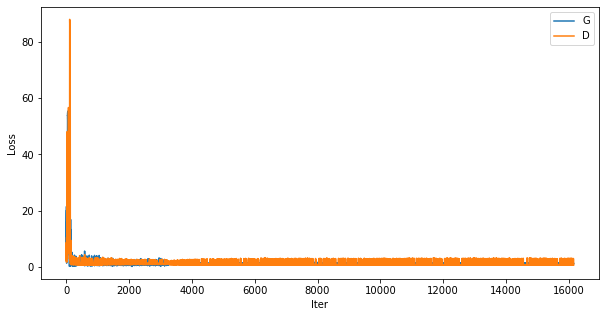

In [7]:
# check loss
plt.figure(figsize=(10,5))
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.legend()
plt.show()

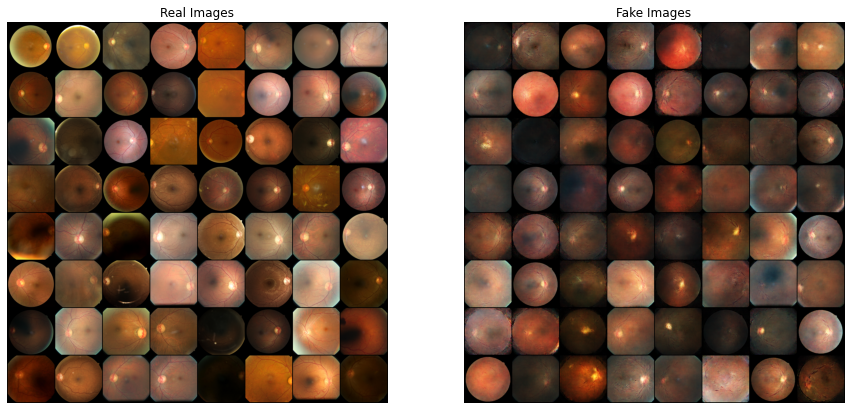

In [8]:
# check images
real_images = next(iter(train_dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.transpose(vutils.make_grid(real_images[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.title("Real Images")

plt.subplot(1,2,2)
fake_images = net_G(fixed_noise).detach().cpu()
fake_images = np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True),(1,2,0))
plt.imshow(fake_images)
plt.axis("off")
plt.title("Fake Images")
plt.show()

In [9]:
#Save
state = {
    'net': net_D.state_dict(),
    'acc': 0,
    'epoch': num_epochs,
}
if not os.path.isdir('checkpoint/exp4'):
    os.mkdir('checkpoint/exp4')
torch.save(state, './checkpoint/exp4/ckpt_IN.pth')